# Multiclass Image Classification using Keras Tensorflow




## Generate Dataset using built in function

Here we use a built in function from keras to import the image directory:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


image_size = (180, 180)
batch_size = 32
dataset_dir = "D:\\Downloads\\CatsDogsPanda\\animals\\animals\\"

##Collect photos in Animal-specific sub-folder in the same Parent Folder


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


# Visualize the Data using Maplotlib

Here wil will visualize the data using matplotlib.  We write a for loop to "take" the next photo in the stack (as uploaded from the original directory) convert it into a numpy array, and use imshow to display them in a 3 by 3 grid.

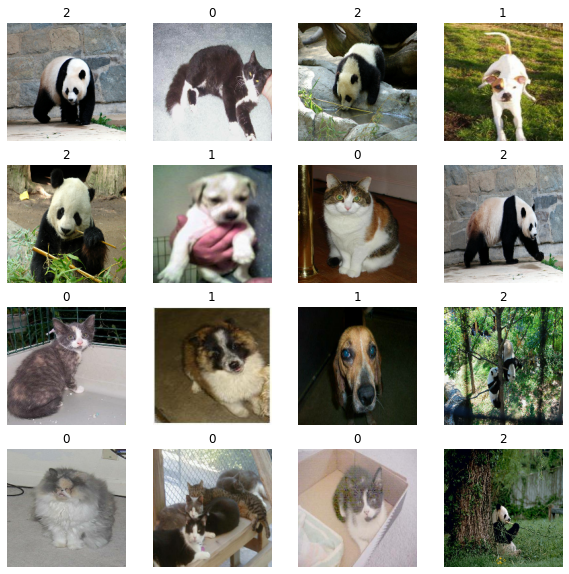

In [27]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Augmenting the Data

In this step we increase our dataset size and variety by taking our photos and flipping them, and rotating them.  


Here we can display what the data augmentation step accompishes by taking  1 original photo, and applying the augment step 9 times.  

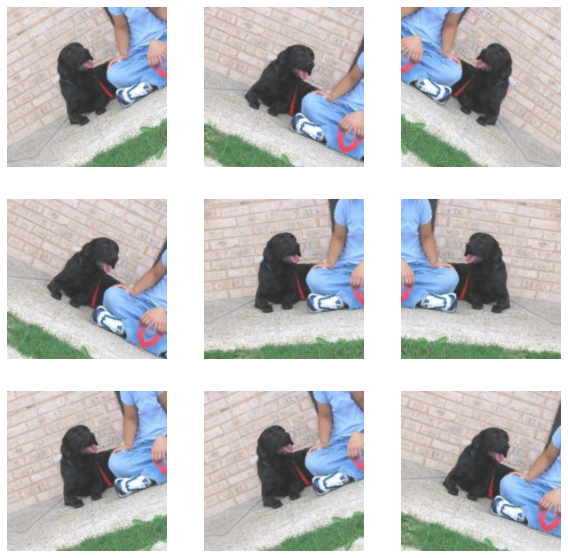

In [4]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [3]:
import numpy as np

# Take one batch of the dataset
for images, labels in train_ds.take(1):
    first_image = images[0]  # Get the first image tensor
    first_image_array = first_image.numpy()  # Convert to numpy array

    # Print the numeric representation of the first image
    print(first_image_array)

    # If you want to print with less decimal places to make it easier to read:
    # np.set_printoptions(precision=2, suppress=True)
    # print(first_image_array)

    break  # Only take the first batch, so break here

[[[145.80556   113.720985   66.89013  ]
  [145.4426    112.522224   67.36296  ]
  [145.58395   112.583954   71.583954 ]
  ...
  [ 69.690765   31.690763   10.690763 ]
  [ 70.95952    31.292953   11.6262045]
  [ 89.50615    43.759792   27.675247 ]]

 [[142.08704   108.8037     68.6537   ]
  [142.85556   109.57222    69.42222  ]
  [135.39445   102.111115   61.961113 ]
  ...
  [ 79.33883    40.48883    19.772163 ]
  [ 89.22226    51.316696   30.983324 ]
  [ 92.60202    54.885357   36.16869  ]]

 [[140.66667   106.57716    71.5      ]
  [149.61111   115.611115   80.22222  ]
  [139.7531    105.75308    67.75308  ]
  ...
  [ 79.7995     37.188393   17.993946 ]
  [ 70.39857    33.398502   13.065129 ]
  [ 63.611134   30.222246   11.222246 ]]

 ...

 [[199.90115   192.51224   176.31778  ]
  [189.89807   181.4351    166.03694  ]
  [198.75618   187.1451    173.53401  ]
  ...
  [164.32101   143.65134   117.79941  ]
  [152.70341   133.01823   104.35166  ]
  [163.12022   144.7036    111.7036   ]]

 [

In [6]:


train_ds = train_ds.prefetch(buffer_size=32)  # Prefetch data for training dataset to improve loading efficiency
val_ds = val_ds.prefetch(buffer_size=32)  # Prefetch data for validation dataset to improve loading efficiency

Here we will actually construct the NN model used for image classification.  The model itself is a basic image processing 2D Convolution Neural Network.  For more information on why this particular model is used for image classification:

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

## Create function to Create our Keras Model using Functional API
##Functional API : start by creating input node with Keras.Input, finish with Keras.Model(input,output)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)  # Define model input shape
    # Assume data_augmentation is defined elsewhere
    x = data_augmentation(inputs)  # Apply data augmentation

    x = layers.Rescaling(1.0 / 255)(x)  # Rescale pixel values
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)  # Apply 2D convolution
    x = layers.BatchNormalization()(x)  # Normalize the activations
    x = layers.Activation("relu")(x)  # Apply ReLU activation

    # Adding MaxPooling right after the first convolution
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)  # Apply 2D convolution
    x = layers.BatchNormalization()(x)  # Normalize the activations
    x = layers.Activation("relu")(x)  # Apply ReLU activation

    previous_block_activation = x  # Store current layer output

    # Simplify the loop for creating multiple layers to accommodate the new MaxPooling
    for size in [128, 256]:
        x = layers.Activation("relu")(x)  # Apply ReLU activation
        x = layers.SeparableConv2D(size, 3, padding="same")(x)  # Apply separable convolution
        x = layers.BatchNormalization()(x)  # Normalize the activations

        x = layers.Activation("relu")(x)  # Apply ReLU activation
        x = layers.SeparableConv2D(size, 3, padding="same")(x)  # Apply separable convolution
        x = layers.BatchNormalization()(x)  # Normalize the activations

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)  # Apply max pooling

        # Create residual connection
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add residual connection
        previous_block_activation = x  # Update residual for next block

    # Continue with the final layers of the model as before
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)  # Apply separable convolution
    x = layers.BatchNormalization()(x)  # Normalize the activations
    x = layers.Activation("relu")(x)  # Apply ReLU activation

    x = layers.GlobalAveragePooling2D()(x)  # Apply global average pooling
    x = layers.Dropout(0.5)(x)  # Apply dropout for regularization

    # Conditional block for output layer settings
    if num_classes == 2:
        activation = "sigmoid"  # Set activation for binary classification
        units = 1  # Set single unit for binary classification
    else:
        activation = "softmax"  # Set activation for multi-class classification
        units = num_classes  # Set units equal to number of classes

    outputs = layers.Dense(units, activation=activation)(x)  # Create output layer
    return keras.Model(inputs, outputs)  # Return the model

# Example usage, assuming 'image_size' and 'data_augmentation' are defined elsewhere
model = make_model(input_shape=image_size + (3,), num_classes=3)

In [9]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
75/75 [==============================] - 27s 354ms/step - loss: 0.4235 - accuracy: 0.8071 - val_loss: 6.5588 - val_accuracy: 0.4083
Epoch 2/50
75/75 [==============================] - 27s 352ms/step - loss: 0.4084 - accuracy: 0.8233 - val_loss: 1.7119 - val_accuracy: 0.6100
Epoch 3/50
75/75 [==============================] - 27s 352ms/step - loss: 0.4261 - accuracy: 0.8146 - val_loss: 2.3908 - val_accuracy: 0.5300
Epoch 4/50
75/75 [==============================] - 27s 353ms/step - loss: 0.4049 - accuracy: 0.8233 - val_loss: 4.9302 - val_accuracy: 0.4217
Epoch 5/50
75/75 [==============================] - 27s 353ms/step - loss: 0.3790 - accuracy: 0.8375 - val_loss: 2.2572 - val_accuracy: 0.4817
Epoch 6/50
75/75 [==============================] - 27s 353ms/step - loss: 0.4026 - accuracy: 0.8271 - val_loss: 4.1876 - val_accuracy: 0.4150
Epoch 7/50
75/75 [==============================] - 27s 352ms/step - loss: 0.3978 - accuracy: 0.8333 - val_loss: 1.2806 - val_accuracy: 0.6483

In [ ]:
val_ds

In [10]:
from tensorflow import keras

# Replace 'path_to_my_checkpoint.h5' with the actual path to your checkpoint file
model_checkpoint_path = 'save_at_50.h5'

# Load the model from the checkpoint
model = keras.models.load_model(model_checkpoint_path)

# After loading, you can use the model to make predictions, evaluate it, or continue training

In [11]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")

19/19 [==============================] - 2s 84ms/step - loss: 0.6844 - accuracy: 0.7767
Validation accuracy: 77.67%


In [14]:
img = keras.preprocessing.image.load_img(
    "D:\\Downloads\\pandaphoto1.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(score)

[0.0788851 0.014855  0.9062599]
